In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.model_selection import train_test_split

In [4]:
#input with all maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
x_data_string=df_spectra_all["all_maxima"].values

max_nr_of_max=df_spectra_all['no_of_max'].max()
len_array=len(df_spectra_all["all_maxima"].values)

print(max_nr_of_max,len_array)
x_data_padded=np.zeros((len_array,max_nr_of_max))

for i,x_string in enumerate(x_data_string):
    x_string=x_string.replace('\n','').replace('[','').replace(']','')
    x_split= x_string.split(' ')
    j=0
    for x in (x_split):
        if(x!=''):
            #print(x)
            x_data_padded[i,j]=float(x)
            j=j+1
    #print("cut")

y_data=df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()


y_data=y_data-0.5
y_data=y_data*4


data_train, data_test, labels_train, labels_test = train_test_split(x_data_padded, y_data, test_size=0.20, random_state=42)
   
print(data_train.shape)

22 729
(583, 22)


def transform_data(df,index):
    data=df[index].to_numpy()
    new_data=np.zeros((len(data),max(data)+1))    
    for i in range(len(data)):
        new_data[i,data[i]]=1
    return new_data
    
df_spectra=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
df_new=df_spectra.loc[df_spectra["k11"] == 0]


x_data=transform_data(df_new,"no_of_max")
print(x_data[0:2])



y_data=df_spectra[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()


y_data=y_data-0.5
y_data=y_data*4
print(y_data[0:10])


data_train, data_test, labels_train, labels_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)

print(data_train.shape)
print(labels_train.shape)

#df_training = df_spectra.sample(frac=0.8,random_state=10)
#df_testing=df_spectra.drop(df_training.index)
#df_spectra.head()

In [9]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("all_maxima")
my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max)

#transform data


In [10]:

def plot_the_loss_curve(epochs, mse,val_mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.plot(epochs, val_mse, label="Val Loss")

    plt.legend()
    #plt.ylim([0, 15])
    plt.show()  

def create_model(my_learning_rate, my_feature_layer):
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    # Define the first hidden layer with 10 nodes.   
   # model.add(my_feature_layer_A)
    #layers=[5,10]
    layers=[2000,3500,300,2000,3000,30,200,300,30]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = 'sigmoid',kernel_regularizer=tf.keras.regularizers.l1(0.0)))
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=6,  
                                    name='Output',activation="sigmoid"))#,kernel_regularizer=tf.keras.regularizers.l2(0.04)))                              
  
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=my_learning_rate,momentum=0.1),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model



def train_model(model, x,y, epochs, label_name,
                batch_size=None):

    #features = {name:np.array(value) for name, value in dataset.items()}
    #label=dataset[label_name].to_numpy()
    history = model.fit(x=x, y=y, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=1,validation_split=0.2) 
    
    epochs = history.epoch
  
    df_hist = pd.DataFrame(history.history)
    #hist.head()
    #mse = hist["mean_squared_error"]
    mae = df_hist["mean_squared_error"].to_numpy()
    val_mae = df_hist["val_mean_squared_error"].to_numpy()
    return epochs,mae,val_mae

In [11]:
# The following variables are the hyperparameters.
#data_train, data_test, labels_train, labels_test
learning_rate = 1e-1
epochs = 500
batch_size = 400

label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]

my_model = create_model(learning_rate, my_feature_layer_A)

epochs, mse,val_mse = train_model(my_model, data_train,labels_train, epochs, 
                          label_name, batch_size)


Epoch 1/500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2/2 [==============================] - ETA: 0s - loss: 0.8979 - mean_squared_error: 0.89 - 0s 97ms/step - loss: 0.8935 - mean_squared_error: 0.8935 - val_loss: 0.8800 - val_mean_squared_error: 0.8800
Epoch 2/500
2/2 [==============================] - ETA: 0s - loss: 0.8676 - mean_squared_error: 0.86 - 0s 39ms/step - loss: 0.8653 - mean_squared_error: 0.8653 - val_loss: 0.8544 - val_mean_squared_error: 0.8544
Epoch 3/500
2/2 [==============================] - ETA: 0s - loss: 0.8386 - mean_squ

2/2 [==============================] - ETA: 0s - loss: 0.6862 - mean_squared_error: 0.68 - 0s 38ms/step - loss: 0.6829 - mean_squared_error: 0.6829 - val_loss: 0.7063 - val_mean_squared_error: 0.7063
Epoch 34/500
2/2 [==============================] - ETA: 0s - loss: 0.6868 - mean_squared_error: 0.68 - ETA: 0s - loss: 0.6822 - mean_squared_error: 0.68 - 0s 42ms/step - loss: 0.6822 - mean_squared_error: 0.6822 - val_loss: 0.7057 - val_mean_squared_error: 0.7057
Epoch 35/500
2/2 [==============================] - ETA: 0s - loss: 0.6819 - mean_squared_error: 0.68 - 0s 39ms/step - loss: 0.6816 - mean_squared_error: 0.6816 - val_loss: 0.7051 - val_mean_squared_error: 0.7051
Epoch 36/500
2/2 [==============================] - ETA: 0s - loss: 0.6803 - mean_squared_error: 0.68 - 0s 39ms/step - loss: 0.6810 - mean_squared_error: 0.6810 - val_loss: 0.7045 - val_mean_squared_error: 0.7045
Epoch 37/500
2/2 [==============================] - ETA: 0s - loss: 0.6733 - mean_squared_error: 0.67 - 0s 39

Epoch 68/500
2/2 [==============================] - ETA: 0s - loss: 0.6688 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6724 - mean_squared_error: 0.6724 - val_loss: 0.6963 - val_mean_squared_error: 0.6963
Epoch 69/500
2/2 [==============================] - ETA: 0s - loss: 0.6737 - mean_squared_error: 0.67 - 0s 39ms/step - loss: 0.6723 - mean_squared_error: 0.6723 - val_loss: 0.6962 - val_mean_squared_error: 0.6962
Epoch 70/500
2/2 [==============================] - ETA: 0s - loss: 0.6704 - mean_squared_error: 0.67 - 0s 38ms/step - loss: 0.6722 - mean_squared_error: 0.6722 - val_loss: 0.6960 - val_mean_squared_error: 0.6960
Epoch 71/500
2/2 [==============================] - ETA: 0s - loss: 0.6695 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6720 - mean_squared_error: 0.6720 - val_loss: 0.6959 - val_mean_squared_error: 0.6959
Epoch 72/500
2/2 [==============================] - ETA: 0s - loss: 0.6686 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6719 - mean_squared_error:

2/2 [==============================] - ETA: 0s - loss: 0.6634 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6696 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6696 - mean_squared_error: 0.6696 - val_loss: 0.6939 - val_mean_squared_error: 0.6939
Epoch 102/500
2/2 [==============================] - ETA: 0s - loss: 0.6700 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6695 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6695 - mean_squared_error: 0.6695 - val_loss: 0.6939 - val_mean_squared_error: 0.6939
Epoch 103/500
2/2 [==============================] - ETA: 0s - loss: 0.6684 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6695 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6695 - mean_squared_error: 0.6695 - val_loss: 0.6939 - val_mean_squared_error: 0.6939
Epoch 104/500
2/2 [==============================] - ETA: 0s - loss: 0.6684 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6694 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6694 - mean_squared_error: 0.6694 - 

Epoch 134/500
2/2 [==============================] - ETA: 0s - loss: 0.6623 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6683 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6683 - mean_squared_error: 0.6683 - val_loss: 0.6925 - val_mean_squared_error: 0.6925
Epoch 135/500
2/2 [==============================] - ETA: 0s - loss: 0.6706 - mean_squared_error: 0.67 - 0s 40ms/step - loss: 0.6683 - mean_squared_error: 0.6683 - val_loss: 0.6925 - val_mean_squared_error: 0.6925
Epoch 136/500
2/2 [==============================] - ETA: 0s - loss: 0.6701 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6682 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6682 - mean_squared_error: 0.6682 - val_loss: 0.6924 - val_mean_squared_error: 0.6924
Epoch 137/500
2/2 [==============================] - ETA: 0s - loss: 0.6727 - mean_squared_error: 0.67 - 0s 39ms/step - loss: 0.6682 - mean_squared_error: 0.6682 - val_loss: 0.6924 - val_mean_squared_error: 0.6924
Epoch 138/500
2/2 [=====================

Epoch 171/500
2/2 [==============================] - ETA: 0s - loss: 0.6632 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6674 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6674 - mean_squared_error: 0.6674 - val_loss: 0.6913 - val_mean_squared_error: 0.6913
Epoch 172/500
2/2 [==============================] - ETA: 0s - loss: 0.6723 - mean_squared_error: 0.67 - 0s 39ms/step - loss: 0.6674 - mean_squared_error: 0.6674 - val_loss: 0.6913 - val_mean_squared_error: 0.6913
Epoch 173/500
2/2 [==============================] - ETA: 0s - loss: 0.6712 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6674 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6674 - mean_squared_error: 0.6674 - val_loss: 0.6913 - val_mean_squared_error: 0.6913
Epoch 174/500
2/2 [==============================] - ETA: 0s - loss: 0.6637 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6674 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6674 - mean_squared_error: 0.6674 - val_loss: 0.6913 - val_mean_squared_er

Epoch 207/500
2/2 [==============================] - ETA: 0s - loss: 0.6704 - mean_squared_error: 0.67 - 0s 38ms/step - loss: 0.6670 - mean_squared_error: 0.6670 - val_loss: 0.6908 - val_mean_squared_error: 0.6908
Epoch 208/500
2/2 [==============================] - ETA: 0s - loss: 0.6715 - mean_squared_error: 0.67 - 0s 42ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - val_loss: 0.6908 - val_mean_squared_error: 0.6908
Epoch 209/500
2/2 [==============================] - ETA: 0s - loss: 0.6716 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6669 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - val_loss: 0.6908 - val_mean_squared_error: 0.6908
Epoch 210/500
2/2 [==============================] - ETA: 0s - loss: 0.6695 - mean_squared_error: 0.66 - 0s 38ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - val_loss: 0.6907 - val_mean_squared_error: 0.6907
Epoch 211/500
2/2 [==============================] - ETA: 0s - loss: 0.6626 - mean_squared_e

Epoch 243/500
2/2 [==============================] - ETA: 0s - loss: 0.6668 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6666 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6905 - val_mean_squared_error: 0.6905
Epoch 244/500
2/2 [==============================] - ETA: 0s - loss: 0.6675 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6905 - val_mean_squared_error: 0.6905
Epoch 245/500
2/2 [==============================] - ETA: 0s - loss: 0.6688 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6905 - val_mean_squared_error: 0.6905
Epoch 246/500
2/2 [==============================] - ETA: 0s - loss: 0.6679 - mean_squared_error: 0.66 - 0s 40ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6904 - val_mean_squared_error: 0.6904
Epoch 247/500
2/2 [==============================] - ETA: 0s - loss: 0.6651 - mean_squared_e

Epoch 280/500
2/2 [==============================] - ETA: 0s - loss: 0.6743 - mean_squared_error: 0.67 - 0s 39ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6902 - val_mean_squared_error: 0.6902
Epoch 281/500
2/2 [==============================] - ETA: 0s - loss: 0.6612 - mean_squared_error: 0.66 - 0s 38ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6901 - val_mean_squared_error: 0.6901
Epoch 282/500
2/2 [==============================] - ETA: 0s - loss: 0.6688 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6901 - val_mean_squared_error: 0.6901
Epoch 283/500
2/2 [==============================] - ETA: 0s - loss: 0.6628 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6901 - val_mean_squared_error: 0.6901
Epoch 284/500
2/2 [==============================] - ETA: 0s - loss: 0.6695 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6664 - mean_squa

Epoch 316/500
2/2 [==============================] - ETA: 0s - loss: 0.6713 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6662 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 317/500
2/2 [==============================] - ETA: 0s - loss: 0.6654 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 318/500
2/2 [==============================] - ETA: 0s - loss: 0.6610 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 319/500
2/2 [==============================] - ETA: 0s - loss: 0.6642 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6662 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 320/500
2/2 [=====================

2/2 [==============================] - ETA: 0s - loss: 0.6633 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6661 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6898 - val_mean_squared_error: 0.6898
Epoch 354/500
2/2 [==============================] - ETA: 0s - loss: 0.6625 - mean_squared_error: 0.66 - 0s 40ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6898 - val_mean_squared_error: 0.6898
Epoch 355/500
2/2 [==============================] - ETA: 0s - loss: 0.6703 - mean_squared_error: 0.67 - 0s 39ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6898 - val_mean_squared_error: 0.6898
Epoch 356/500
2/2 [==============================] - ETA: 0s - loss: 0.6622 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6898 - val_mean_squared_error: 0.6898
Epoch 357/500
2/2 [==============================] - ETA: 0s - loss: 0.6678 - mean_squared_error: 0.66 - 0

Epoch 387/500
2/2 [==============================] - ETA: 0s - loss: 0.6563 - mean_squared_error: 0.65 - ETA: 0s - loss: 0.6660 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6897 - val_mean_squared_error: 0.6897
Epoch 388/500
2/2 [==============================] - ETA: 0s - loss: 0.6699 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6660 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6897 - val_mean_squared_error: 0.6897
Epoch 389/500
2/2 [==============================] - ETA: 0s - loss: 0.6699 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6659 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6897 - val_mean_squared_error: 0.6897
Epoch 390/500
2/2 [==============================] - ETA: 0s - loss: 0.6743 - mean_squared_error: 0.67 - 0s 38ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6897 - val_mean_squared_er

2/2 [==============================] - ETA: 0s - loss: 0.6617 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6895 - val_mean_squared_error: 0.6895
Epoch 421/500
2/2 [==============================] - ETA: 0s - loss: 0.6682 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6895 - val_mean_squared_error: 0.6895
Epoch 422/500
2/2 [==============================] - ETA: 0s - loss: 0.6694 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6895 - val_mean_squared_error: 0.6895
Epoch 423/500
2/2 [==============================] - ETA: 0s - loss: 0.6707 - mean_squared_error: 0.67 - 0s 39ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6895 - val_mean_squared_error: 0.6895
Epoch 424/500
2/2 [==============================] - ETA: 0s - loss: 0.6634 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6658 - mean_squared_error: 0.66 - 0

2/2 [==============================] - ETA: 0s - loss: 0.6657 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6658 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6894 - val_mean_squared_error: 0.6894
Epoch 455/500
2/2 [==============================] - ETA: 0s - loss: 0.6653 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6658 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6894 - val_mean_squared_error: 0.6894
Epoch 456/500
2/2 [==============================] - ETA: 0s - loss: 0.6656 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6658 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6894 - val_mean_squared_error: 0.6894
Epoch 457/500
2/2 [==============================] - ETA: 0s - loss: 0.6696 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6894 - val_mean_squared_error: 0.6894
Ep

2/2 [==============================] - ETA: 0s - loss: 0.6599 - mean_squared_error: 0.65 - 0s 39ms/step - loss: 0.6657 - mean_squared_error: 0.6657 - val_loss: 0.6893 - val_mean_squared_error: 0.6893
Epoch 488/500
2/2 [==============================] - ETA: 0s - loss: 0.6690 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6657 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6657 - mean_squared_error: 0.6657 - val_loss: 0.6893 - val_mean_squared_error: 0.6893
Epoch 489/500
2/2 [==============================] - ETA: 0s - loss: 0.6645 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6657 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6657 - mean_squared_error: 0.6657 - val_loss: 0.6893 - val_mean_squared_error: 0.6893
Epoch 490/500
2/2 [==============================] - ETA: 0s - loss: 0.6563 - mean_squared_error: 0.65 - 0s 41ms/step - loss: 0.6657 - mean_squared_error: 0.6657 - val_loss: 0.6893 - val_mean_squared_error: 0.6893
Epoch 491/500
2/2 [==============================] - E

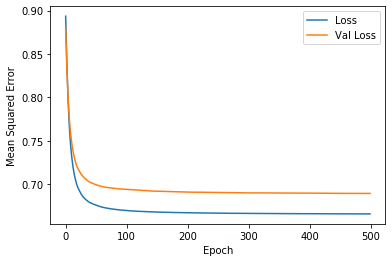

1/1 [==============================] - ETA: 0s - loss: 0.6583 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6583 - mean_squared_error: 0.6583
[0.6582716107368469, 0.6582716107368469]


,k6a1_test,k6a2_test,k11_test,k12_test,k9a1_test,k9a2_test,k6a1_hat,k6a2_hat,k11_hat,k12_hat,k9a1_hat,k9a2_hat
0,0.0,1.0,1.0,0.0,-1.0,-1.0,0.060630,0.025852,0.026553,0.0269,0.026644,0.039053
1,-1.0,0.0,1.0,0.0,0.0,0.0,0.060631,0.025852,0.026553,0.0269,0.026644,0.039053
2,0.0,-1.0,1.0,-1.0,0.0,1.0,0.060631,0.025852,0.026553,0.0269,0.026644,0.039053
3,0.0,0.0,0.0,-1.0,0.0,0.0,0.060631,0.025852,0.026553,0.0269,0.026644,0.039053
4,1.0,-1.0,0.0,-1.0,-1.0,1.0,0.060631,0.025852,0.026553,0.0269,0.026644,0.039053


In [16]:
#features = {name:np.array(value) for name, value in df_test.items()}
#label=df_test[label_name].to_numpy()
#data_train, data_test, labels_train, labels_test
plot_the_loss_curve(epochs, mse,val_mse)
evaluation=my_model.evaluate(x = data_test, y = labels_test, batch_size=batch_size)
predicted = my_model.predict(data_test)
print(evaluation)



df_test=pd.DataFrame(labels_test,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
pd.concat([df_test,df_predict], axis=1).head()

In [357]:
print(data_test[0:5])
print(labels_test[0:5])


[[-0.124  0.184  0.466  0.808  0.858  0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.462  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [-0.932 -0.774 -0.706 -0.628 -0.488 -0.424 -0.34  -0.17  -0.086 -0.032
   0.12   0.142  0.204  0.274  0.456  0.508  0.586  0.73   0.812  0.864
   0.91   0.   ]
 [-0.42   0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [-0.932 -0.772 -0.704 -0.628 -0.488 -0.424 -0.34  -0.178 -0.136 -0.084
  -0.034  0.116  0.202  0.274  0.456  0.506  0.592  0.73   0.81   0.864
   0.912  0.   ]]
[[ 0.  1.  1.  0. -1. -1.]
 [-1.  0.  1.  0.  0.  0.]
 [ 0. -1.  1. -1.  0.  1.]
 [ 0.  0.  0. -1.  0.  0.]
 [ 1. -1.  0. -1. -1.  1.]]


In [28]:
#new try with 2d Data:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.model_selection import train_test_split


def get_array_from_strings(data_string, padded_array):
    use_paddad_array=padded_array.copy()
    for i,x_string in enumerate(data_string):
        x_string=x_string.replace('\n','').replace('[','').replace(']','')
        x_split= x_string.split(' ')
        j=0
        for x in (x_split):
            if(x!=''):
                #print(x)
                use_paddad_array[i,j]=float(x)
                j=j+1

    return use_paddad_array

In [196]:
#input with all maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks_with_intensity.csv",index_col=[0])
x_Energy_string=df_spectra_all["all_maxima"].values
x_Intensity_string=df_spectra_all["Intensity"].values



max_nr_of_max=df_spectra_all['no_of_max'].max()
len_array=len(df_spectra_all["all_maxima"].values)

print(max_nr_of_max,len_array)
x_data_padded=np.zeros((len_array,max_nr_of_max))


x_energy_padded=get_array_from_strings(x_Energy_string,x_data_padded)
x_Intensity_padded=get_array_from_strings(x_Intensity_string,x_data_padded)

#print(x_data_padded[:5])    
#print(x_energy_padded[:5])    
#print(x_Intensity_padded[:5])    

#make 2d Array from Energy and Intensity
x_data_2d =np.zeros((len(x_energy_padded),len(x_energy_padded[0]),2))
for i in range(len(x_energy_padded)):
    for j in range(len(x_energy_padded[i])):
        x_data_2d[i,j,0]=x_energy_padded[i,j]
        x_data_2d[i,j,1]=x_Intensity_padded[i,j]

print(x_data_2d[:5]) 

#convert y_data into 2d array where -1=[1,0] 0=[0,0] 1=[0,1]
y_data=df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()
y_data=y_data-0.5
y_data=y_data*4
y_data_2d =np.zeros((len(y_data),len(y_data[0]),2))
#print(y_data_2d.shape)
for i in range(len(y_data)):
    for j in range(len(y_data[i])):
        if(y_data[i,j]==-1):
            y_data_2d[i,j,0]=1
        elif(y_data[i,j]==1):
            y_data_2d[i,j,1]=1
            
#print(y_data[:5])
#print(y_data_2d[:5])
#this is with 2d label
#data_train, data_test, labels_train, labels_test = train_test_split(x_data_2d, y_data_2d, test_size=0.20, random_state=42)

#this is with 1d label
data_train, data_test, labels_train, labels_test = train_test_split(x_data_2d, y_data, test_size=0.20, random_state=42)




#maybe reshape data into [nr,x,y,channel=1?]   
print(data_train.shape)
print(labels_train.shape)

22 729
[[[-7.58000000e-01  5.20690186e+00]
  [-6.90000000e-01  6.88780025e+00]
  [-6.12000000e-01  3.55071480e+00]
  [-4.72000000e-01  6.73106847e+00]
  [-4.06000000e-01  6.52867583e+00]
  [-3.28000000e-01  2.03445274e+00]
  [-1.52000000e-01  5.86586448e+00]
  [-6.80000000e-02  4.57587849e+00]
  [-1.40000000e-02  3.76715204e+00]
  [ 1.34000000e-01  6.36630283e+00]
  [ 2.22000000e-01  4.15754817e+00]
  [ 2.94000000e-01  3.10619177e+00]
  [ 4.72000000e-01  5.88775394e+00]
  [ 5.24000000e-01  4.05543485e+00]
  [ 6.02000000e-01  5.13470720e+00]
  [ 7.48000000e-01  7.85833443e+00]
  [ 8.24000000e-01  2.62504489e+00]
  [ 8.82000000e-01  4.22528457e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[-5.74000000e-01  2.38435403e+01]
  [-4.80000000e-02  1.10445002e+01]
  [ 3.40000000e-02  1.50444894e+01]
  [ 5.96000000e-01  1.12537878e+01]
  [ 6.58000000e-01  1.48091845e+01]
  [ 0.00000000e+00 

In [205]:

def plot_the_loss_curve(epochs, mse,val_mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.plot(epochs, val_mse, label="Val Loss")

    plt.legend()
    #plt.ylim([0, 15])
    plt.show()  

def create_2d_model(my_learning_rate, input_shape):
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    # Define the first hidden layer with 10 nodes.   
    
    model.add(tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape=input_shape))
    model.add(tf.keras.layers.Conv1D(12, 3, activation='relu'))
    model.add(tf.keras.layers.Conv1D(32, 4, activation='relu'))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = 6, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1(0.0)))

    
    
    
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=my_learning_rate,momentum=0.1),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model



def train_model(model, x,y, epochs,
                batch_size=None):

    #features = {name:np.array(value) for name, value in dataset.items()}
    #label=dataset[label_name].to_numpy()
    history = model.fit(x=x, y=y, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=1,validation_split=0.1) 
    
    epochs = history.epoch
  
    df_hist = pd.DataFrame(history.history)
    #hist.head()
    #mse = hist["mean_squared_error"]
    mae = df_hist["mean_squared_error"].to_numpy()
    val_mae = df_hist["val_mean_squared_error"].to_numpy()
    return epochs,mae,val_mae

In [206]:
#data_train,data_test,labels_train,labels_test
input_shape=(data_train.shape[1:3])
print(input_shape)
print(input_shape)



(22, 2)
(22, 2)


In [226]:
two_d_model=create_2d_model(0.001,(22,2))

In [229]:
epochs, mse,val_mse =train_model(two_d_model,data_train,labels_train,1500)

Epoch 1/1500
17/17 [==============================] - ETA: 0s - loss: 0.6445 - mean_squared_error: 0.64 - ETA: 0s - loss: 0.6671 - mean_squared_error: 0.66 - 0s 6ms/step - loss: 0.6671 - mean_squared_error: 0.6671 - val_loss: 0.6944 - val_mean_squared_error: 0.6944
Epoch 2/1500
17/17 [==============================] - ETA: 0s - loss: 0.7265 - mean_squared_error: 0.72 - 0s 2ms/step - loss: 0.6671 - mean_squared_error: 0.6671 - val_loss: 0.6944 - val_mean_squared_error: 0.6944
Epoch 3/1500
17/17 [==============================] - ETA: 0s - loss: 0.6406 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6671 - mean_squared_error: 0.6671 - val_loss: 0.6944 - val_mean_squared_error: 0.6944
Epoch 4/1500
17/17 [==============================] - ETA: 0s - loss: 0.6548 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6671 - mean_squared_error: 0.6671 - val_loss: 0.6945 - val_mean_squared_error: 0.6945
Epoch 5/1500
17/17 [==============================] - ETA: 0s - loss: 0.6583 - mean_squared_

Epoch 39/1500
17/17 [==============================] - ETA: 0s - loss: 0.6843 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - val_loss: 0.6951 - val_mean_squared_error: 0.6951
Epoch 40/1500
17/17 [==============================] - ETA: 0s - loss: 0.6657 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - val_loss: 0.6952 - val_mean_squared_error: 0.6952
Epoch 41/1500
17/17 [==============================] - ETA: 0s - loss: 0.6809 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - val_loss: 0.6952 - val_mean_squared_error: 0.6952
Epoch 42/1500
17/17 [==============================] - ETA: 0s - loss: 0.6615 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - val_loss: 0.6952 - val_mean_squared_error: 0.6952
Epoch 43/1500
17/17 [==============================] - ETA: 0s - loss: 0.6125 - mean_squared_error: 0.61 - 0s 2ms/step - loss: 0.6669 - mean

17/17 [==============================] - ETA: 0s - loss: 0.6389 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.6668 - mean_squared_error: 0.6668 - val_loss: 0.6956 - val_mean_squared_error: 0.6956
Epoch 78/1500
17/17 [==============================] - ETA: 0s - loss: 0.6618 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6668 - mean_squared_error: 0.6668 - val_loss: 0.6956 - val_mean_squared_error: 0.6956
Epoch 79/1500
17/17 [==============================] - ETA: 0s - loss: 0.6558 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6668 - mean_squared_error: 0.6668 - val_loss: 0.6956 - val_mean_squared_error: 0.6956
Epoch 80/1500
17/17 [==============================] - ETA: 0s - loss: 0.6476 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6667 - mean_squared_error: 0.6667 - val_loss: 0.6957 - val_mean_squared_error: 0.6957
Epoch 81/1500
17/17 [==============================] - ETA: 0s - loss: 0.6496 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6667 - mean_squared_error

17/17 [==============================] - ETA: 0s - loss: 0.7101 - mean_squared_error: 0.71 - 0s 2ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6960 - val_mean_squared_error: 0.6960
Epoch 116/1500
17/17 [==============================] - ETA: 0s - loss: 0.6788 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6959 - val_mean_squared_error: 0.6959
Epoch 117/1500
17/17 [==============================] - ETA: 0s - loss: 0.6582 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6960 - val_mean_squared_error: 0.6960
Epoch 118/1500
17/17 [==============================] - ETA: 0s - loss: 0.6770 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6960 - val_mean_squared_error: 0.6960
Epoch 119/1500
17/17 [==============================] - ETA: 0s - loss: 0.6170 - mean_squared_error: 0.61 - 0s 3ms/step - loss: 0.6666 - mean_squared_e

Epoch 153/1500
17/17 [==============================] - ETA: 0s - loss: 0.6161 - mean_squared_error: 0.61 - 0s 2ms/step - loss: 0.6665 - mean_squared_error: 0.6665 - val_loss: 0.6963 - val_mean_squared_error: 0.6963
Epoch 154/1500
17/17 [==============================] - ETA: 0s - loss: 0.6894 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6665 - mean_squared_error: 0.6665 - val_loss: 0.6963 - val_mean_squared_error: 0.6963
Epoch 155/1500
17/17 [==============================] - ETA: 0s - loss: 0.6846 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6665 - mean_squared_error: 0.6665 - val_loss: 0.6962 - val_mean_squared_error: 0.6962
Epoch 156/1500
17/17 [==============================] - ETA: 0s - loss: 0.6876 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6665 - mean_squared_error: 0.6665 - val_loss: 0.6962 - val_mean_squared_error: 0.6962
Epoch 157/1500
17/17 [==============================] - ETA: 0s - loss: 0.6749 - mean_squared_error: 0.67 - 0s 3ms/step - loss: 0.6665 -

Epoch 191/1500
17/17 [==============================] - ETA: 0s - loss: 0.6485 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6665 - mean_squared_error: 0.6665 - val_loss: 0.6969 - val_mean_squared_error: 0.6969
Epoch 192/1500
17/17 [==============================] - ETA: 0s - loss: 0.6554 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6665 - mean_squared_error: 0.6665 - val_loss: 0.6968 - val_mean_squared_error: 0.6968
Epoch 193/1500
17/17 [==============================] - ETA: 0s - loss: 0.6465 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6665 - mean_squared_error: 0.6665 - val_loss: 0.6968 - val_mean_squared_error: 0.6968
Epoch 194/1500
17/17 [==============================] - ETA: 0s - loss: 0.6370 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.6665 - mean_squared_error: 0.6665 - val_loss: 0.6968 - val_mean_squared_error: 0.6968
Epoch 195/1500
17/17 [==============================] - ETA: 0s - loss: 0.6478 - mean_squared_error: 0.64 - 0s 3ms/step - loss: 0.6665 -

Epoch 229/1500
17/17 [==============================] - ETA: 0s - loss: 0.6158 - mean_squared_error: 0.61 - 0s 2ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6971 - val_mean_squared_error: 0.6971
Epoch 230/1500
17/17 [==============================] - ETA: 0s - loss: 0.6701 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6971 - val_mean_squared_error: 0.6971
Epoch 231/1500
17/17 [==============================] - ETA: 0s - loss: 0.7073 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6970 - val_mean_squared_error: 0.6970
Epoch 232/1500
17/17 [==============================] - ETA: 0s - loss: 0.6514 - mean_squared_error: 0.65 - 0s 3ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6970 - val_mean_squared_error: 0.6970
Epoch 233/1500
17/17 [==============================] - ETA: 0s - loss: 0.6815 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6664 -

Epoch 267/1500
17/17 [==============================] - ETA: 0s - loss: 0.6681 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6972 - val_mean_squared_error: 0.6972
Epoch 268/1500
17/17 [==============================] - ETA: 0s - loss: 0.6755 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6972 - val_mean_squared_error: 0.6972
Epoch 269/1500
17/17 [==============================] - ETA: 0s - loss: 0.5645 - mean_squared_error: 0.56 - 0s 2ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6972 - val_mean_squared_error: 0.6972
Epoch 270/1500
17/17 [==============================] - ETA: 0s - loss: 0.6791 - mean_squared_error: 0.67 - 0s 3ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6971 - val_mean_squared_error: 0.6971
Epoch 271/1500
17/17 [==============================] - ETA: 0s - loss: 0.6958 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6664 -

Epoch 305/1500
17/17 [==============================] - ETA: 0s - loss: 0.6915 - mean_squared_error: 0.69 - 0s 3ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - val_loss: 0.6972 - val_mean_squared_error: 0.6972
Epoch 306/1500
17/17 [==============================] - ETA: 0s - loss: 0.6655 - mean_squared_error: 0.66 - 0s 3ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - val_loss: 0.6972 - val_mean_squared_error: 0.6972
Epoch 307/1500
17/17 [==============================] - ETA: 0s - loss: 0.5807 - mean_squared_error: 0.58 - 0s 3ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - val_loss: 0.6972 - val_mean_squared_error: 0.6972
Epoch 308/1500
17/17 [==============================] - ETA: 0s - loss: 0.6307 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - val_loss: 0.6973 - val_mean_squared_error: 0.6973
Epoch 309/1500
17/17 [==============================] - ETA: 0s - loss: 0.6975 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6663 -

Epoch 343/1500
17/17 [==============================] - ETA: 0s - loss: 0.6337 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - val_loss: 0.6976 - val_mean_squared_error: 0.6976
Epoch 344/1500
17/17 [==============================] - ETA: 0s - loss: 0.6358 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - val_loss: 0.6975 - val_mean_squared_error: 0.6975
Epoch 345/1500
17/17 [==============================] - ETA: 0s - loss: 0.7003 - mean_squared_error: 0.70 - 0s 3ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - val_loss: 0.6975 - val_mean_squared_error: 0.6975
Epoch 346/1500
17/17 [==============================] - ETA: 0s - loss: 0.6710 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - val_loss: 0.6975 - val_mean_squared_error: 0.6975
Epoch 347/1500
17/17 [==============================] - ETA: 0s - loss: 0.6139 - mean_squared_error: 0.61 - 0s 2ms/step - loss: 0.6663 -

Epoch 381/1500
17/17 [==============================] - ETA: 0s - loss: 0.6745 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6979 - val_mean_squared_error: 0.6979
Epoch 382/1500
17/17 [==============================] - ETA: 0s - loss: 0.6785 - mean_squared_error: 0.67 - 0s 3ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6979 - val_mean_squared_error: 0.6979
Epoch 383/1500
17/17 [==============================] - ETA: 0s - loss: 0.6925 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6978 - val_mean_squared_error: 0.6978
Epoch 384/1500
17/17 [==============================] - ETA: 0s - loss: 0.6529 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6979 - val_mean_squared_error: 0.6979
Epoch 385/1500
17/17 [==============================] - ETA: 0s - loss: 0.6992 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6662 -

Epoch 419/1500
17/17 [==============================] - ETA: 0s - loss: 0.6868 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6978 - val_mean_squared_error: 0.6978
Epoch 420/1500
17/17 [==============================] - ETA: 0s - loss: 0.6708 - mean_squared_error: 0.67 - 0s 3ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6978 - val_mean_squared_error: 0.6978
Epoch 421/1500
17/17 [==============================] - ETA: 0s - loss: 0.6834 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6978 - val_mean_squared_error: 0.6978
Epoch 422/1500
17/17 [==============================] - ETA: 0s - loss: 0.7108 - mean_squared_error: 0.71 - 0s 2ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6977 - val_mean_squared_error: 0.6977
Epoch 423/1500
17/17 [==============================] - ETA: 0s - loss: 0.6495 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6662 -

Epoch 457/1500
17/17 [==============================] - ETA: 0s - loss: 0.6587 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6979 - val_mean_squared_error: 0.6979
Epoch 458/1500
17/17 [==============================] - ETA: 0s - loss: 0.7109 - mean_squared_error: 0.71 - 0s 3ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6979 - val_mean_squared_error: 0.6979
Epoch 459/1500
17/17 [==============================] - ETA: 0s - loss: 0.6200 - mean_squared_error: 0.62 - 0s 2ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6979 - val_mean_squared_error: 0.6979
Epoch 460/1500
17/17 [==============================] - ETA: 0s - loss: 0.6677 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6979 - val_mean_squared_error: 0.6979
Epoch 461/1500
17/17 [==============================] - ETA: 0s - loss: 0.7078 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 0.6662 -

Epoch 495/1500
17/17 [==============================] - ETA: 0s - loss: 0.6791 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6981 - val_mean_squared_error: 0.6981
Epoch 496/1500
17/17 [==============================] - ETA: 0s - loss: 0.6152 - mean_squared_error: 0.61 - 0s 2ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6982 - val_mean_squared_error: 0.6982
Epoch 497/1500
17/17 [==============================] - ETA: 0s - loss: 0.7534 - mean_squared_error: 0.75 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6981 - val_mean_squared_error: 0.6981
Epoch 498/1500
17/17 [==============================] - ETA: 0s - loss: 0.6950 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6981 - val_mean_squared_error: 0.6981
Epoch 499/1500
17/17 [==============================] - ETA: 0s - loss: 0.6808 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6662 -

Epoch 533/1500
17/17 [==============================] - ETA: 0s - loss: 0.6403 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6982 - val_mean_squared_error: 0.6982
Epoch 534/1500
17/17 [==============================] - ETA: 0s - loss: 0.7093 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6981 - val_mean_squared_error: 0.6981
Epoch 535/1500
17/17 [==============================] - ETA: 0s - loss: 0.6814 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6982 - val_mean_squared_error: 0.6982
Epoch 536/1500
17/17 [==============================] - ETA: 0s - loss: 0.6456 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6981 - val_mean_squared_error: 0.6981
Epoch 537/1500
17/17 [==============================] - ETA: 0s - loss: 0.6998 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6661 -

Epoch 571/1500
17/17 [==============================] - ETA: 0s - loss: 0.7045 - mean_squared_error: 0.70 - 0s 3ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6985 - val_mean_squared_error: 0.6985
Epoch 572/1500
17/17 [==============================] - ETA: 0s - loss: 0.6188 - mean_squared_error: 0.61 - 0s 3ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6984 - val_mean_squared_error: 0.6984
Epoch 573/1500
17/17 [==============================] - ETA: 0s - loss: 0.6790 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6985 - val_mean_squared_error: 0.6985
Epoch 574/1500
17/17 [==============================] - ETA: 0s - loss: 0.7083 - mean_squared_error: 0.70 - 0s 3ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6984 - val_mean_squared_error: 0.6984
Epoch 575/1500
17/17 [==============================] - ETA: 0s - loss: 0.6923 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6661 -

Epoch 609/1500
17/17 [==============================] - ETA: 0s - loss: 0.6692 - mean_squared_error: 0.66 - 0s 3ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6985 - val_mean_squared_error: 0.6985
Epoch 610/1500
17/17 [==============================] - ETA: 0s - loss: 0.6802 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6984 - val_mean_squared_error: 0.6984
Epoch 611/1500
17/17 [==============================] - ETA: 0s - loss: 0.6840 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6984 - val_mean_squared_error: 0.6984
Epoch 612/1500
17/17 [==============================] - ETA: 0s - loss: 0.6603 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6985 - val_mean_squared_error: 0.6985
Epoch 613/1500
17/17 [==============================] - ETA: 0s - loss: 0.6610 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6661 -

Epoch 647/1500
17/17 [==============================] - ETA: 0s - loss: 0.6433 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6985 - val_mean_squared_error: 0.6985
Epoch 648/1500
17/17 [==============================] - ETA: 0s - loss: 0.6531 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6985 - val_mean_squared_error: 0.6985
Epoch 649/1500
17/17 [==============================] - ETA: 0s - loss: 0.7027 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6984 - val_mean_squared_error: 0.6984
Epoch 650/1500
17/17 [==============================] - ETA: 0s - loss: 0.6689 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6984 - val_mean_squared_error: 0.6984
Epoch 651/1500
17/17 [==============================] - ETA: 0s - loss: 0.7155 - mean_squared_error: 0.71 - 0s 2ms/step - loss: 0.6661 -

Epoch 685/1500
17/17 [==============================] - ETA: 0s - loss: 0.6944 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 686/1500
17/17 [==============================] - ETA: 0s - loss: 0.6514 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 687/1500
17/17 [==============================] - ETA: 0s - loss: 0.6833 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 688/1500
17/17 [==============================] - ETA: 0s - loss: 0.7002 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 689/1500
17/17 [==============================] - ETA: 0s - loss: 0.6542 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6661 -

Epoch 723/1500
17/17 [==============================] - ETA: 0s - loss: 0.6205 - mean_squared_error: 0.62 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6986 - val_mean_squared_error: 0.6986
Epoch 724/1500
17/17 [==============================] - ETA: 0s - loss: 0.6620 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6986 - val_mean_squared_error: 0.6986
Epoch 725/1500
17/17 [==============================] - ETA: 0s - loss: 0.6561 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 726/1500
17/17 [==============================] - ETA: 0s - loss: 0.6716 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 727/1500
17/17 [==============================] - ETA: 0s - loss: 0.6930 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6660 -

Epoch 761/1500
17/17 [==============================] - ETA: 0s - loss: 0.6650 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6988 - val_mean_squared_error: 0.6988
Epoch 762/1500
17/17 [==============================] - ETA: 0s - loss: 0.6295 - mean_squared_error: 0.62 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6988 - val_mean_squared_error: 0.6988
Epoch 763/1500
17/17 [==============================] - ETA: 0s - loss: 0.6262 - mean_squared_error: 0.62 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 764/1500
17/17 [==============================] - ETA: 0s - loss: 0.6645 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 765/1500
17/17 [==============================] - ETA: 0s - loss: 0.6734 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6660 -

Epoch 799/1500
17/17 [==============================] - ETA: 0s - loss: 0.6373 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 800/1500
17/17 [==============================] - ETA: 0s - loss: 0.6129 - mean_squared_error: 0.61 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 801/1500
17/17 [==============================] - ETA: 0s - loss: 0.6759 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 802/1500
17/17 [==============================] - ETA: 0s - loss: 0.6886 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 803/1500
17/17 [==============================] - ETA: 0s - loss: 0.6706 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6660 -

Epoch 837/1500
17/17 [==============================] - ETA: 0s - loss: 0.6508 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6988 - val_mean_squared_error: 0.6988
Epoch 838/1500
17/17 [==============================] - ETA: 0s - loss: 0.7027 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 839/1500
17/17 [==============================] - ETA: 0s - loss: 0.6260 - mean_squared_error: 0.62 - 0s 3ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 840/1500
17/17 [==============================] - ETA: 0s - loss: 0.6903 - mean_squared_error: 0.69 - 0s 3ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6987 - val_mean_squared_error: 0.6987
Epoch 841/1500
17/17 [==============================] - ETA: 0s - loss: 0.6183 - mean_squared_error: 0.61 - 0s 2ms/step - loss: 0.6660 -

Epoch 875/1500
17/17 [==============================] - ETA: 0s - loss: 0.7208 - mean_squared_error: 0.72 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 876/1500
17/17 [==============================] - ETA: 0s - loss: 0.6827 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 877/1500
17/17 [==============================] - ETA: 0s - loss: 0.6026 - mean_squared_error: 0.60 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6989 - val_mean_squared_error: 0.6989
Epoch 878/1500
17/17 [==============================] - ETA: 0s - loss: 0.6692 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6989 - val_mean_squared_error: 0.6989
Epoch 879/1500
17/17 [==============================] - ETA: 0s - loss: 0.6445 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6660 -

Epoch 913/1500
17/17 [==============================] - ETA: 0s - loss: 0.6359 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 914/1500
17/17 [==============================] - ETA: 0s - loss: 0.6711 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 915/1500
17/17 [==============================] - ETA: 0s - loss: 0.6704 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 916/1500
17/17 [==============================] - ETA: 0s - loss: 0.6286 - mean_squared_error: 0.62 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 917/1500
17/17 [==============================] - ETA: 0s - loss: 0.6627 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6660 -

Epoch 951/1500
17/17 [==============================] - ETA: 0s - loss: 0.6839 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6989 - val_mean_squared_error: 0.6989
Epoch 952/1500
17/17 [==============================] - ETA: 0s - loss: 0.6190 - mean_squared_error: 0.61 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6989 - val_mean_squared_error: 0.6989
Epoch 953/1500
17/17 [==============================] - ETA: 0s - loss: 0.7152 - mean_squared_error: 0.71 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6989 - val_mean_squared_error: 0.6989
Epoch 954/1500
17/17 [==============================] - ETA: 0s - loss: 0.6871 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 955/1500
17/17 [==============================] - ETA: 0s - loss: 0.6444 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6659 -

Epoch 989/1500
17/17 [==============================] - ETA: 0s - loss: 0.7261 - mean_squared_error: 0.72 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 990/1500
17/17 [==============================] - ETA: 0s - loss: 0.6751 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 991/1500
17/17 [==============================] - ETA: 0s - loss: 0.6299 - mean_squared_error: 0.62 - 0s 3ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6990 - val_mean_squared_error: 0.6990
Epoch 992/1500
17/17 [==============================] - ETA: 0s - loss: 0.6583 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6989 - val_mean_squared_error: 0.6989
Epoch 993/1500
17/17 [==============================] - ETA: 0s - loss: 0.6329 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.6659 -

Epoch 1027/1500
17/17 [==============================] - ETA: 0s - loss: 0.7243 - mean_squared_error: 0.72 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1028/1500
17/17 [==============================] - ETA: 0s - loss: 0.6698 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1029/1500
17/17 [==============================] - ETA: 0s - loss: 0.6716 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1030/1500
17/17 [==============================] - ETA: 0s - loss: 0.6771 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1031/1500
17/17 [==============================] - ETA: 0s - loss: 0.6943 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6

Epoch 1065/1500
17/17 [==============================] - ETA: 0s - loss: 0.7202 - mean_squared_error: 0.72 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6991 - val_mean_squared_error: 0.6991
Epoch 1066/1500
17/17 [==============================] - ETA: 0s - loss: 0.6837 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6991 - val_mean_squared_error: 0.6991
Epoch 1067/1500
17/17 [==============================] - ETA: 0s - loss: 0.7049 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6991 - val_mean_squared_error: 0.6991
Epoch 1068/1500
17/17 [==============================] - ETA: 0s - loss: 0.7089 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6991 - val_mean_squared_error: 0.6991
Epoch 1069/1500
17/17 [==============================] - ETA: 0s - loss: 0.6807 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6

Epoch 1103/1500
17/17 [==============================] - ETA: 0s - loss: 0.6569 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6991 - val_mean_squared_error: 0.6991
Epoch 1104/1500
17/17 [==============================] - ETA: 0s - loss: 0.6703 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6991 - val_mean_squared_error: 0.6991
Epoch 1105/1500
17/17 [==============================] - ETA: 0s - loss: 0.6420 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1106/1500
17/17 [==============================] - ETA: 0s - loss: 0.6763 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1107/1500
17/17 [==============================] - ETA: 0s - loss: 0.6774 - mean_squared_error: 0.67 - 0s 3ms/step - loss: 0.6

Epoch 1141/1500
17/17 [==============================] - ETA: 0s - loss: 0.6479 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1142/1500
17/17 [==============================] - ETA: 0s - loss: 0.7412 - mean_squared_error: 0.74 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1143/1500
17/17 [==============================] - ETA: 0s - loss: 0.6592 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1144/1500
17/17 [==============================] - ETA: 0s - loss: 0.7422 - mean_squared_error: 0.74 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1145/1500
17/17 [==============================] - ETA: 0s - loss: 0.6813 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6

Epoch 1179/1500
17/17 [==============================] - ETA: 0s - loss: 0.6737 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1180/1500
17/17 [==============================] - ETA: 0s - loss: 0.6953 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1181/1500
17/17 [==============================] - ETA: 0s - loss: 0.6648 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1182/1500
17/17 [==============================] - ETA: 0s - loss: 0.6450 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1183/1500
17/17 [==============================] - ETA: 0s - loss: 0.6725 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6

Epoch 1217/1500
17/17 [==============================] - ETA: 0s - loss: 0.6529 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1218/1500
17/17 [==============================] - ETA: 0s - loss: 0.6355 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1219/1500
17/17 [==============================] - ETA: 0s - loss: 0.6016 - mean_squared_error: 0.60 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1220/1500
17/17 [==============================] - ETA: 0s - loss: 0.6900 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6994 - val_mean_squared_error: 0.6994
Epoch 1221/1500
17/17 [==============================] - ETA: 0s - loss: 0.6678 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6

Epoch 1255/1500
17/17 [==============================] - ETA: 0s - loss: 0.6890 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1256/1500
17/17 [==============================] - ETA: 0s - loss: 0.6653 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1257/1500
17/17 [==============================] - ETA: 0s - loss: 0.6633 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1258/1500
17/17 [==============================] - ETA: 0s - loss: 0.6659 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1259/1500
17/17 [==============================] - ETA: 0s - loss: 0.6817 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6

Epoch 1293/1500
17/17 [==============================] - ETA: 0s - loss: 0.7157 - mean_squared_error: 0.71 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6994 - val_mean_squared_error: 0.6994
Epoch 1294/1500
17/17 [==============================] - ETA: 0s - loss: 0.7248 - mean_squared_error: 0.72 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6994 - val_mean_squared_error: 0.6994
Epoch 1295/1500
17/17 [==============================] - ETA: 0s - loss: 0.6820 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6994 - val_mean_squared_error: 0.6994
Epoch 1296/1500
17/17 [==============================] - ETA: 0s - loss: 0.6340 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6994 - val_mean_squared_error: 0.6994
Epoch 1297/1500
17/17 [==============================] - ETA: 0s - loss: 0.7012 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 0.6

Epoch 1331/1500
17/17 [==============================] - ETA: 0s - loss: 0.6890 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 1332/1500
17/17 [==============================] - ETA: 0s - loss: 0.6606 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1333/1500
17/17 [==============================] - ETA: 0s - loss: 0.6955 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1334/1500
17/17 [==============================] - ETA: 0s - loss: 0.6637 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1335/1500
17/17 [==============================] - ETA: 0s - loss: 0.6614 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6

Epoch 1369/1500
17/17 [==============================] - ETA: 0s - loss: 0.6291 - mean_squared_error: 0.62 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6994 - val_mean_squared_error: 0.6994
Epoch 1370/1500
17/17 [==============================] - ETA: 0s - loss: 0.6599 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6994 - val_mean_squared_error: 0.6994
Epoch 1371/1500
17/17 [==============================] - ETA: 0s - loss: 0.6421 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6994 - val_mean_squared_error: 0.6994
Epoch 1372/1500
17/17 [==============================] - ETA: 0s - loss: 0.6845 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6994 - val_mean_squared_error: 0.6994
Epoch 1373/1500
17/17 [==============================] - ETA: 0s - loss: 0.7337 - mean_squared_error: 0.73 - 0s 3ms/step - loss: 0.6

Epoch 1407/1500
17/17 [==============================] - ETA: 0s - loss: 0.6708 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1408/1500
17/17 [==============================] - ETA: 0s - loss: 0.6993 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1409/1500
17/17 [==============================] - ETA: 0s - loss: 0.6723 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6993 - val_mean_squared_error: 0.6993
Epoch 1410/1500
17/17 [==============================] - ETA: 0s - loss: 0.6908 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6994 - val_mean_squared_error: 0.6994
Epoch 1411/1500
17/17 [==============================] - ETA: 0s - loss: 0.6592 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6

Epoch 1445/1500
17/17 [==============================] - ETA: 0s - loss: 0.6439 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6996 - val_mean_squared_error: 0.6996
Epoch 1446/1500
17/17 [==============================] - ETA: 0s - loss: 0.6679 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6996 - val_mean_squared_error: 0.6996
Epoch 1447/1500
17/17 [==============================] - ETA: 0s - loss: 0.6879 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6996 - val_mean_squared_error: 0.6996
Epoch 1448/1500
17/17 [==============================] - ETA: 0s - loss: 0.6610 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6996 - val_mean_squared_error: 0.6996
Epoch 1449/1500
17/17 [==============================] - ETA: 0s - loss: 0.6640 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 0.6

Epoch 1483/1500
17/17 [==============================] - ETA: 0s - loss: 0.6953 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6996 - val_mean_squared_error: 0.6996
Epoch 1484/1500
17/17 [==============================] - ETA: 0s - loss: 0.6471 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6996 - val_mean_squared_error: 0.6996
Epoch 1485/1500
17/17 [==============================] - ETA: 0s - loss: 0.6207 - mean_squared_error: 0.62 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6997 - val_mean_squared_error: 0.6997
Epoch 1486/1500
17/17 [==============================] - ETA: 0s - loss: 0.6919 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6997 - val_mean_squared_error: 0.6997
Epoch 1487/1500
17/17 [==============================] - ETA: 0s - loss: 0.6801 - mean_squared_error: 0.68 - 0s 3ms/step - loss: 0.6

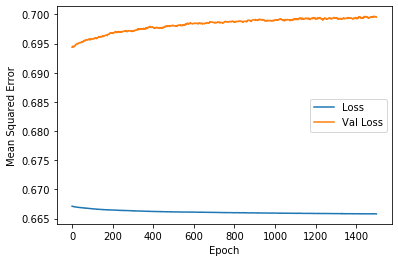

ValueError: in user code:

    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:941 test_function  *
        outputs = self.distribute_strategy.run(
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:909 test_step  **
        y_pred = self(x, training=False)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__
        self.name)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 22 but received input with shape [None, 22, 2]


In [230]:
#features = {name:np.array(value) for name, value in df_test.items()}
#label=df_test[label_name].to_numpy()
#data_train, data_test, labels_train, labels_test
plot_the_loss_curve(epochs, mse,val_mse)
evaluation=my_model.evaluate(x = data_test, y = labels_test)
predicted = my_model.predict(data_test)
print(evaluation)



df_test=pd.DataFrame(labels_test,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
pd.concat([df_test,df_predict], axis=1).head()